In [1]:
import os
import bilby
import numpy as np 
import itertools
import matplotlib
from glob import glob
import matplotlib.pyplot as plt
import corner
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import seaborn as sns

In [30]:
def new_rcParams(width='column'):
    
    scale_factor = 2

    if width == 'column':
        fig_width_pt = scale_factor*246.0
        fs = scale_factor*7.96
        aspect_ratio=(1 + 5 ** 0.5) / 2/1.25
    elif width == 'page':
        fig_width_pt = scale_factor*510.0
        fs = scale_factor*9
        aspect_ratio=2.8
    inches_per_pt = 1.0/72.27

    fig_width = fig_width_pt*inches_per_pt
    fig_height = fig_width/aspect_ratio

    figsize = (fig_width, fig_height)

    new_params = {}
    new_params['figure.figsize'] = figsize
    new_params['font.size'] = fs
    new_params['text.usetex'] = True
    new_params['text.latex.preamble'] = r'\usepackage{mathrsfs}\usepackage{amsmath}\usepackage{amssymb}'
    new_params['axes.labelsize'] = 'medium'
    new_params['font.family'] = 'serif'
    new_params['font.serif'] = 'times'
    new_params['mathtext.fontset'] = 'stix'
    new_params['xtick.direction'] = 'in'
    new_params['ytick.direction'] = 'in'
    new_params['xtick.minor.visible'] = True
    new_params['ytick.minor.visible'] = True
    new_params['legend.fontsize'] = 'medium'
    new_params['legend.handlelength'] = 1.5
    
    return new_params

color_palette = {
    'primary': '#0072B2',
    'secondary':  '#CC79A7',
    'tertiary': '#009E73',
    'color3'    : '#D55E00',
    'color4'    : '#56B4E9',
    'color5'    : '#40B0A6',
    'color6'    : '#E69F00',
    'color7'    : '#DC3220',
    'LLO': '#3953a4',
    'LHO': '#ed2024',
    'colormap': 'viridis'
}

import matplotlib.pyplot as plt
plt.rcParams.update(new_rcParams())
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import SymLogNorm

## Injections

In [3]:
mchirpratio, snrratio = [.5, 1., 2.], [.5, 1.]
delta_tc = [-.1, -.05, -.03, -.02, -.01, .01, .02, .03, .05, .1]

combinations = list(itertools.product(mchirpratio, snrratio, delta_tc))

data_a, data_b = [], []
mchirp_a, mchirp_b = np.zeros(len(combinations)), np.zeros(len(combinations))
q_a, q_b = np.zeros(len(combinations)), np.zeros(len(combinations))
eta_a, eta_b = np.zeros(len(combinations)), np.zeros(len(combinations))
eff_spin_a, eff_spin_b = np.zeros(len(combinations)), np.zeros(len(combinations))
delta_tc, snr_a, snr_b = np.zeros(len(combinations)), np.zeros(len(combinations)), np.zeros(len(combinations))

for i in range(len(combinations)):
    data_a.append(np.load('../../output/pe_population/injections/SINGLES_A_{}_{}_{}.npy'.format(combinations[i][0], combinations[i][1], combinations[i][2]), allow_pickle=True).item())
    data_b.append(np.load('../../output/pe_population/injections/SINGLES_B_{}_{}_{}.npy'.format(combinations[i][0], combinations[i][1], combinations[i][2]), allow_pickle=True).item())

    mchirp_a[i], mchirp_b[i] = np.power(data_a[i]['mass_1']*data_a[i]['mass_2'], (3/5))/np.power(data_a[i]['mass_1']+data_a[i]['mass_2'], (1/5)), np.power(data_b[i]['mass_1']*data_b[i]['mass_2'], (3/5))/np.power(data_b[i]['mass_1']+data_b[i]['mass_2'], (1/5))
    q_a[i], q_b[i] = data_a[i]['mass_2']/data_a[i]['mass_1'], data_b[i]['mass_2']/data_b[i]['mass_1']
    eta_a[i], eta_b[i] = (data_a[i]['mass_1']*data_a[i]['mass_2'])/np.power(data_a[i]['mass_1']+data_a[i]['mass_2'], 2), (data_b[i]['mass_1']*data_b[i]['mass_2'])/np.power(data_b[i]['mass_1']+data_b[i]['mass_2'], 2)
    eff_spin_a[i], eff_spin_b[i] = data_a[i]['a_1'], data_b[i]['a_1']

    delta_tc[i] = data_b[i]['geocent_time'] - data_a[i]['geocent_time']
    snr_a[i], snr_b[i] = data_a[i]['snr_det'], data_b[i]['snr_det']

## Unlensed Quasi-Circular Recovery

In [4]:
mchirp, log_bayes_factor = np.zeros(len(combinations)), np.zeros(len(combinations))
for i in range(len(combinations)):
    fs = glob('../../output/pe_population/final_result/PE_{}_{}_{}/*'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
    result = bilby.result.read_in_result(filename=fs[0])

    mchirp[i] = result.posterior['chirp_mass'].median()
    log_bayes_factor[i] = result.log_10_bayes_factor

10:47 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for legacy decoding will be removed in a future release.
10:47 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:47 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for legacy decoding will be removed in a future release.
10:47 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:47 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for leg

In [5]:
snr = np.zeros(len(combinations))
for i in range(len(combinations)):
    fs = glob('../../output/pe_population/final_result/PE_{}_{}_{}/*'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
    result = bilby.result.read_in_result(filename=fs[0])
    snr[i] = np.sqrt(result.posterior['H1_optimal_snr'].median()**2+result.posterior['L1_optimal_snr'].median()**2+result.posterior['V1_optimal_snr'].median()**2)

10:47 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for legacy decoding will be removed in a future release.
10:47 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:47 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for legacy decoding will be removed in a future release.
10:47 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:47 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for leg

In [6]:
# for i in range(len(combinations)):
#     fs = glob('../../output/pe_population/final_result/PE_{}_{}_{}/*'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     result = bilby.result.read_in_result(filename=fs[0])

#     plot1 = result.plot_{\\rm c}orner(
#         parameters=["chirp_mass", "mass_ratio"], save=False
#     )
#     plot1.axes[0].axvline(mchirp_a[i], color='r', linestyle='--')
#     plot1.axes[0].axvline(mchirp_b[i], color='m', linestyle='--')
#     plot1.axes[3].axvline(q_a[i], color='r', linestyle='--')
#     plot1.axes[3].axvline(q_b[i], color='m', linestyle='--')
#     plot1.axes[1].text(0.5, 0.5, '$\\mathscr{{M}}_A={}$\n$\\mathscr{{M}}_B={}$\n$q_A={}$\n$q_B={}$'.format(round(mchirp_a[i],2), round(mchirp_b[i],2), round(q_a[i],2), round(q_b[i], 2)), horizontalalignment='center', verticalalignment='center', transform=plot1.axes[1].transAxes)
#     plot1.suptitle('$\\mathrm{{SNR}}_{{\\rm A}}/\\mathrm{{SNR}}_{{\\rm B}}={}$\n$\\mathscr{{M}}_A/\\mathscr{{M}}_B={}\ \\&\ \\Delta t_{\\rm c}={}$'.format(round(snr_a[i]/snr_b[i],2), round(mchirp_a[i]/mchirp_b[i],2), round(delta_tc[i],3)))
#     plot1.set_size_inches(8, 8)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/pe/Mq_PE_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()
    
#     plot2 = result.plot_{\\rm c}orner(
#         parameters=["mass_1", "mass_2"], save=False
#     )
#     plot2.axes[0].axvline(data_a[i]['mass_1'], color='r', linestyle='--')
#     plot2.axes[0].axvline(data_b[i]['mass_1'], color='m', linestyle='--')
#     plot2.axes[3].axvline(data_a[i]['mass_2'], color='r', linestyle='--')
#     plot2.axes[3].axvline(data_b[i]['mass_2'], color='m', linestyle='--')
#     plot2.axes[1].text(0.5, 0.5, '$m_{{1A}}={}$\n$m_{{1B}}={}$\n$m_{{2A}}={}$\n$m_{{2B}}={}$'.format(round(data_a[i]['mass_1'],2), round(data_b[i]['mass_1'],2), round(data_a[i]['mass_2'],2), round(data_b[i]['mass_2'], 2)), horizontalalignment='center', verticalalignment='center', transform=plot2.axes[1].transAxes)
#     plot2.suptitle('$\\mathrm{{SNR}}_{{\\rm A}}/\\mathrm{{SNR}}_{{\\rm B}}={}$\n$\\mathscr{{M}}_A/\\mathscr{{M}}_B={}\ \\&\ \\Delta t_{\\rm c}={}$'.format(round(snr_a[i]/snr_b[i],2), round(mchirp_a[i]/mchirp_b[i],2), round(delta_tc[i],3)))
#     plot2.set_size_inches(8, 8)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/pe/m1m2_PE_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()

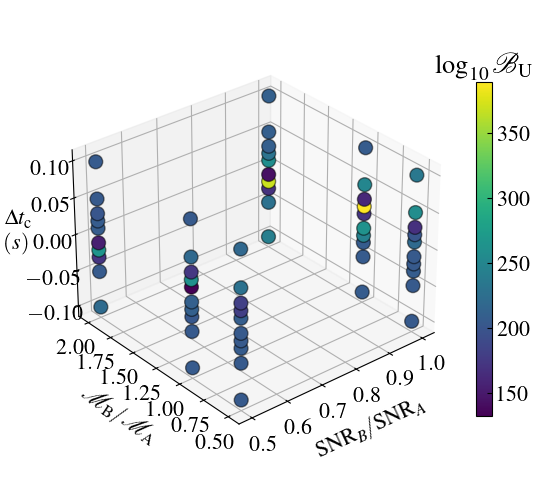

In [7]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

scatter = axes.scatter(snr_b/snr_a, mchirp_b/mchirp_a, delta_tc, c=log_bayes_factor, edgecolor=(0, 0, 0, 0.5), cmap=color_palette['colormap'], depthshade=False, s=100)
axes.set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$', labelpad=12)
axes.set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$', labelpad=12)
axes.zaxis.set_rotate_label(False)
axes.set_zlabel('$\\Delta t_{\\rm c}$\n$(s)$', labelpad=8) 
axes.ticklabel_format(useOffset=False, style='plain')
axes.azim = 230
axes.set_box_aspect(None, zoom=0.835)

clb = fig.colorbar(scatter, ax=axes, shrink=0.7, pad=-0.02)
clb.ax.set_title('$\\log_{10} \\mathscr{B}_{\\rm U}$')

plt.tight_layout()
plt.show()

### Cummulative Plots

In [8]:
bias_mchirp_a = np.abs(mchirp-mchirp_a)/mchirp_a*100
bias_mchirp_b = np.abs(mchirp-mchirp_b)/mchirp_b*100

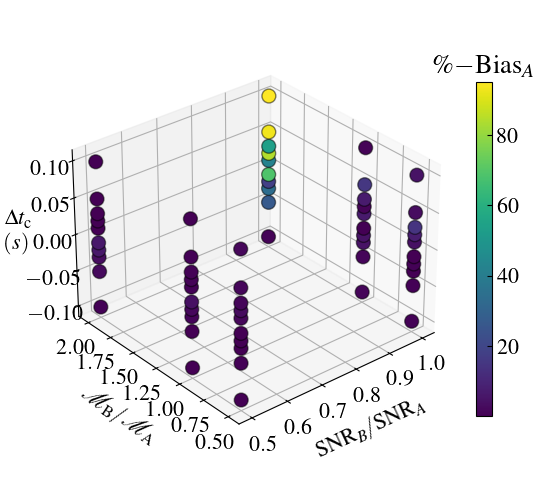

In [9]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

scatter = axes.scatter(snr_b/snr_a, mchirp_b/mchirp_a, delta_tc, c=bias_mchirp_a, edgecolor=(0, 0, 0, 0.5), cmap=color_palette['colormap'], depthshade=False, s=100)
axes.set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$', labelpad=12)
axes.set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$', labelpad=12)
axes.zaxis.set_rotate_label(False)
axes.set_zlabel('$\\Delta t_{\\rm c}$\n$(s)$', labelpad=8) 
axes.ticklabel_format(useOffset=False, style='plain')
axes.azim = 230
axes.set_box_aspect(None, zoom=0.835)

clb = fig.colorbar(scatter, ax=axes, shrink=0.7, pad=-0.02)
clb.ax.set_title('$\\%-$Bias$_A$')

plt.tight_layout()

plt.savefig('../../output/pe_population/output/SinglesPE1.pdf', dpi=600, bbox_inches='tight')
plt.show()

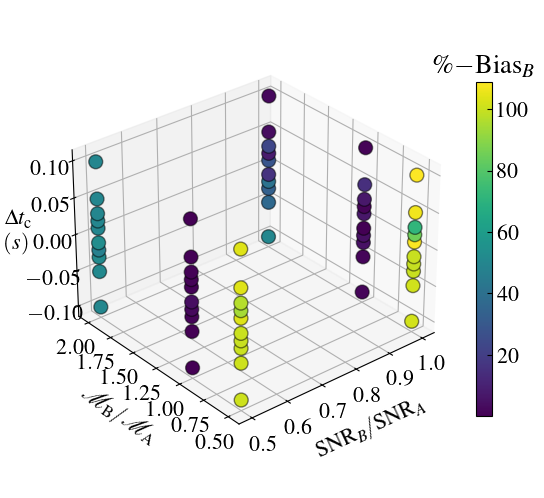

In [10]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

scatter = axes.scatter(snr_b/snr_a, mchirp_b/mchirp_a, delta_tc, c=bias_mchirp_b, edgecolor=(0, 0, 0, 0.5), cmap=color_palette['colormap'], depthshade=False, s=100)
axes.set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$', labelpad=12)
axes.set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$', labelpad=12)
axes.zaxis.set_rotate_label(False)
axes.set_zlabel('$\\Delta t_{\\rm c}$\n$(s)$', labelpad=8) 
axes.ticklabel_format(useOffset=False, style='plain')
axes.azim = 230
axes.set_box_aspect(None, zoom=0.835)

clb = fig.colorbar(scatter, ax=axes, shrink=0.7, pad=-0.02)
clb.ax.set_title('$\\%-$Bias$_B$')

plt.tight_layout()

plt.savefig('../../output/pe_population/output/SinglesPE2.pdf', dpi=600, bbox_inches='tight')
plt.show()

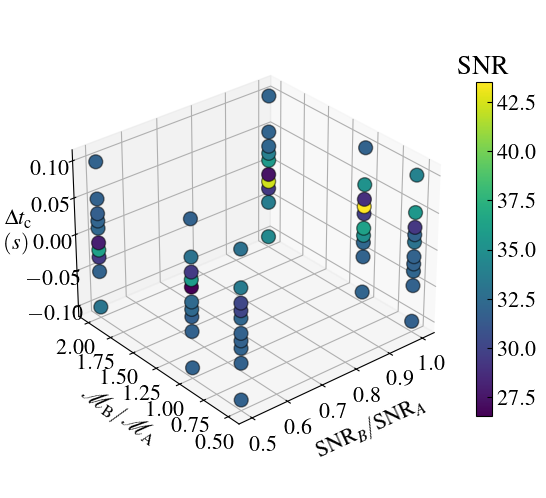

In [11]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

scatter = axes.scatter(snr_b/snr_a, mchirp_b/mchirp_a, delta_tc, c=snr, edgecolor=(0, 0, 0, 0.5), cmap=color_palette['colormap'], depthshade=False, s=100)
axes.set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$', labelpad=12)
axes.set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$', labelpad=12)
axes.zaxis.set_rotate_label(False)
axes.set_zlabel('$\\Delta t_{\\rm c}$\n$(s)$', labelpad=8) 
axes.ticklabel_format(useOffset=False, style='plain')
axes.azim = 230
axes.set_box_aspect(None, zoom=0.835)

clb = fig.colorbar(scatter, ax=axes, shrink=0.7, pad=-0.02)
clb.ax.set_title('$\\mathrm{SNR}$')

plt.tight_layout()

plt.savefig('../../output/pe_population/output/SinglesPE3.pdf', dpi=600, bbox_inches='tight')
plt.show()

## Lensed Recovery

In [12]:
mchirp_ml, log_bayes_factor_ml, t_ml = np.zeros(len(combinations)), np.zeros(len(combinations)), np.zeros(len(combinations))
Mlz_recovered, yl_recovered = np.zeros(len(combinations)), np.zeros(len(combinations))
for i in range(len(combinations)):
    try:
        fs = glob('../../output/pe_population/final_result/PE_ML_{}_{}_{}/*'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
        result = bilby.result.read_in_result(filename=fs[0])
        Mlz_recovered[i] = 10**(result.posterior['Log_Mlz'].median())
        yl_recovered[i] = result.posterior['yl'].median()
        mchirp_ml[i] = result.posterior['chirp_mass'].median()
        log_bayes_factor_ml[i] = result.log_10_bayes_factor
        t_ml[i] = result.posterior['geocent_time'].median()
    except:
        Mlz_recovered[i], yl_recovered[i], mchirp_ml[i], log_bayes_factor_ml[i], t_ml[i] = np.nan, np.nan, np.nan, np.nan, np.nan

log_bayes_factor_ml_diff = log_bayes_factor_ml-log_bayes_factor

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
10:47 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:47 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:47 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:47 bilby INFO    : Global

In [13]:
# for i in range(len(combinations)):
#     try:
#         fs = glob('../../output/pe_population/final_result/PE_ML_{}_{}_{}/*'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#         result = bilby.result.read_in_result(filename=fs[0])
#     except:
#         continue

#     plot1 = result.plot_{\\rm c}orner(
#         parameters=["chirp_mass", "mass_ratio"], save=False
#     )
#     plot1.axes[0].axvline(mchirp_a[i], color='r', linestyle='--')
#     plot1.axes[0].axvline(mchirp_b[i], color='m', linestyle='--')
#     plot1.axes[3].axvline(q_a[i], color='r', linestyle='--')
#     plot1.axes[3].axvline(q_b[i], color='m', linestyle='--')
#     plot1.axes[1].text(0.5, 0.5, '$\\mathscr{{M}}_A={}$\n$\\mathscr{{M}}_B={}$\n$q_A={}$\n$q_B={}$'.format(round(mchirp_a[i],2), round(mchirp_b[i],2), round(q_a[i],2), round(q_b[i], 2)), horizontalalignment='center', verticalalignment='center', transform=plot1.axes[1].transAxes)
#     plot1.suptitle('$\\mathrm{{SNR}}_{{\\rm A}}/\\mathrm{{SNR}}_{{\\rm B}}={}$\n$\\mathscr{{M}}_A/\\mathscr{{M}}_B={}\ \\&\ \\Delta t_{\\rm c}={}$'.format(round(snr_a[i]/snr_b[i],2), round(mchirp_a[i]/mchirp_b[i],2), round(delta_tc[i],3)))
#     plot1.set_size_inches(8, 8)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/pe_ml/Mq_PE_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()
    
#     plot2 = result.plot_{\\rm c}orner(
#         parameters=["mass_1", "mass_2"], save=False
#     )
#     plot2.axes[0].axvline(data_a[i]['mass_1'], color='r', linestyle='--')
#     plot2.axes[0].axvline(data_b[i]['mass_1'], color='m', linestyle='--')
#     plot2.axes[3].axvline(data_a[i]['mass_2'], color='r', linestyle='--')
#     plot2.axes[3].axvline(data_b[i]['mass_2'], color='m', linestyle='--')
#     plot2.axes[1].text(0.5, 0.5, '$m_{{1A}}={}$\n$m_{{1B}}={}$\n$m_{{2A}}={}$\n$m_{{2B}}={}$'.format(round(data_a[i]['mass_1'],2), round(data_b[i]['mass_1'],2), round(data_a[i]['mass_2'],2), round(data_b[i]['mass_2'], 2)), horizontalalignment='center', verticalalignment='center', transform=plot2.axes[1].transAxes)
#     plot2.suptitle('$\\mathrm{{SNR}}_{{\\rm A}}/\\mathrm{{SNR}}_{{\\rm B}}={}$\n$\\mathscr{{M}}_A/\\mathscr{{M}}_B={}\ \\&\ \\Delta t_{\\rm c}={}$'.format(round(snr_a[i]/snr_b[i],2), round(mchirp_a[i]/mchirp_b[i],2), round(delta_tc[i],3)))
#     plot2.set_size_inches(8, 8)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/pe_ml/m1m2_PE_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()

#     plot3 = result.plot_{\\rm c}orner(
#         parameters=["Log_Mlz", "yl"], save=False
#     )
#     plot3.suptitle('$\\mathrm{{SNR}}_{{\\rm A}}/\\mathrm{{SNR}}_{{\\rm B}}={}$\n$\\mathscr{{M}}_A/\\mathscr{{M}}_B={}\ \\&\ \\Delta t_{\\rm c}={}$'.format(round(snr_a[i]/snr_b[i],2), round(mchirp_a[i]/mchirp_b[i],2), round(delta_tc[i],3)))
#     plot3.set_size_inches(8, 8)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/pe_ml/Mlz_yl_PE_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()

10:48 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:48 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:48 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:48 bilby INFO    : Global meta data was removed from the result object for compatibility

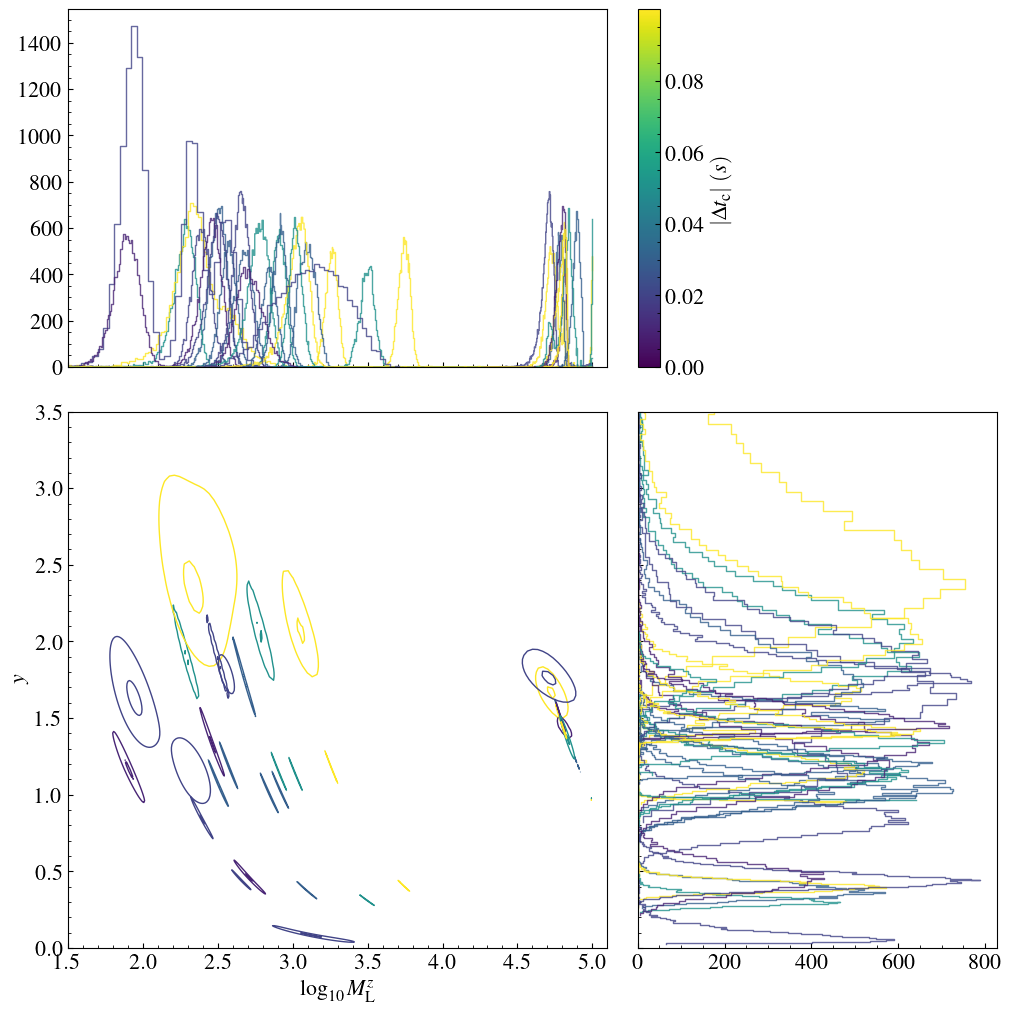

In [31]:
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(delta_tc)), cmap=color_palette['colormap'])
results = []
fig = None

fig, axes = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'width_ratios':[3,2], 'height_ratios':[2,3], 'wspace':0.05, 'hspace':0.05}, layout='constrained')
ax_xhist = axes[0,0]
ax_empty = axes[0,1]
ax_kde = axes[1,0]
ax_yhist = axes[1,1]

ax_xhist.tick_params(axis='x', labelbottom=False)
ax_yhist.tick_params(axis='y', labelleft=False)

skip_indices = np.where(log_bayes_factor_ml_diff < 0.5)[0]

for i in range(len(combinations)):
    try:
        fs = glob('../../output/pe_population/final_result/PE_ML_{}_{}_{}/*'.format(
        combinations[i][0], combinations[i][1], combinations[i][2]))
        result = bilby.result.read_in_result(filename=fs[0])
        results.append(result)
    except:
        results.append(np.nan)
    
    samples = np.vstack([result.posterior['Log_Mlz'], result.posterior['yl']]).T

    color = sm.to_rgba(np.abs(delta_tc[i]))
    label = '{}-{}-{}'.format(combinations[i][0], combinations[i][1], combinations[i][2])

    if i in skip_indices:
        continue
    else:
        alpha = 0.8

    sns.histplot(
                x=samples[:, 0],
                ax=ax_xhist,
                element='step',
                fill=False,
                linewidth=1.0,
                alpha=alpha,
                multiple='layer',
                kde=False,
                color=color,
            )

    sns.histplot(
                y=samples[:, 1],
                ax=ax_yhist,
                element='step',
                fill=False,
                linewidth=1.0,
                alpha=alpha,
                multiple='layer',
                kde=False,
                color=color,
            )

    sns.kdeplot(
                x=samples[:, 0], 
                y=samples[:, 1], 
                ax=ax_kde,
                color=color,
                levels=(0.5,0.95),
                bw_adjust=1.5,
                thresh=0.03,
                linewidths=1.0, 
                fill=False
            )
    
ax_xhist.set_xlabel('$\\log_{10}{M}_{\\rm L}^z$')
ax_xhist.set_ylabel(None)
ax_kde.set_xlabel('$\\log_{10}{M}_{\\rm L}^z$')
ax_kde.set_ylabel('$y$')
ax_yhist.set_xlabel(None)
ax_yhist.set_ylabel('$y$')

ax_kde.set_xlim(1.5, 5.1)
ax_kde.set_ylim(0, 3.5)
ax_xhist.sharex(ax_kde)
ax_yhist.sharey(ax_kde)

xlim = ax_kde.get_xlim()
ylim = ax_kde.get_ylim()
ax_xhist.set_xlim(xlim)
ax_yhist.set_ylim(ylim)

divider = make_axes_locatable(ax_empty)
cax = divider.append_axes("left", size="8%")
ax_empty.set_visible(False)

cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(r'$|\Delta t_{\rm c}|\ (s)$')

plt.show()
plt.close()

In [32]:
def time_delay_dimensionless(yl):
    return (yl * np.sqrt(yl**2 + 4)) / 2.0 + np.log((np.sqrt(yl**2 + 4) + yl) / (np.sqrt(yl**2 + 4) - yl))

def time_delay(Mlz, yl):
    return (4*lal.G_SI*Mlz*lal.MSUN_SI*time_delay_dimensionless(yl))/(lal.C_SI**3)

skip_indices = np.where(log_bayes_factor_ml_diff < 0.5)[0]

time_delays = []
for i in range(len(Mlz_recovered)):
    if i in skip_indices:
        time_delays.append(np.nan)
    else:
        time_delays.append(time_delay(Mlz_recovered[i], yl_recovered[i]))
time_delays = np.array(time_delays)

10:51 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:51 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:51 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:51 bilby INFO    : Global meta data was removed from the result object for compatibility

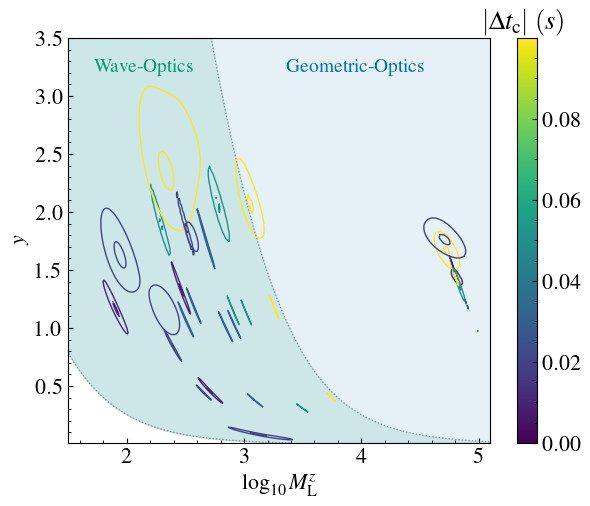

In [33]:
plt.rcParams.update(new_rcParams(width='column'))

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(delta_tc)), cmap=color_palette['colormap'])
results = []
fig = None

fig, axes = plt.subplots()

for i in range(len(combinations)):
    try:
        fs = glob('../../output/pe_population/final_result/PE_ML_{}_{}_{}/*'.format(
        combinations[i][0], combinations[i][1], combinations[i][2]))
        result = bilby.result.read_in_result(filename=fs[0])
        results.append(result)
    except:
        results.append(np.nan)
    
    samples = np.vstack([result.posterior['Log_Mlz'], result.posterior['yl']]).T

    color = sm.to_rgba(np.abs(delta_tc[i]))
    label = '{}-{}-{}'.format(combinations[i][0], combinations[i][1], combinations[i][2])

    if i in skip_indices:
        continue
    else:
        alpha = 0.8

    sns.kdeplot(
                x=samples[:, 0], 
                y=samples[:, 1], 
                ax=axes,
                color=color,
                levels=(0.5,0.95),
                bw_adjust=1.5,
                thresh=0.03,
                linewidths=1.0, 
                fill=False
            )

def LogMlz_at_td(td, y, zl=0):
    Msun_to_sec = lal.G_SI * lal.MSUN_SI / lal.C_SI**3
    Mlz = td / time_delay_dimensionless(y) / Msun_to_sec / 4
    return np.log10(Mlz)

axes.set_xlim(1.5, 5.1)
axes.set_ylim(0.01, 3.5)
Mlzs = np.logspace(np.log10(axes.get_xlim()[0]), np.log10(axes.get_xlim()[1]), 700)
yls = np.linspace(axes.get_ylim()[0], axes.get_ylim()[1], 700)
Ml, yl = np.meshgrid(Mlzs, yls)
axes.fill_betweenx(yls, LogMlz_at_td(1/1e1, yls), LogMlz_at_td(1/1e3, yls), color=color_palette['tertiary'], alpha=0.1)
axes.fill_betweenx(yls, LogMlz_at_td(1/1e3, yls), axes.get_xlim()[1], color=color_palette['primary'], alpha=0.1)

CS = axes.contour(
    Ml, yl, time_delay(10**Ml, yl),
    levels=[1e-3, 1e-1],
    colors='gray',
    linestyles='dotted',
    linewidths=0.9,
    alpha=0.9
)

axes.text(2.15, 3.25, 'Wave-Optics', fontsize=14, fontweight='bold', ha='center', va='center', zorder=5, color=color_palette['tertiary'])
axes.text(3.95, 3.25, 'Geometric-Optics', fontsize=14, fontweight='bold', ha='center', va='center', zorder=5, color=color_palette['primary'])

axes.set_xlabel('$\\log_{10}{M}_{\\rm L}^z$')
axes.set_ylabel('$y$')

cbar = fig.colorbar(sm, ax=axes, orientation='vertical')
cbar.ax.set_title(r'$|\Delta t_{\rm c}|\ (s)$')

plt.savefig('../../output/pe_population/output/MicrolensedRecoveryParametersHist.pdf', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

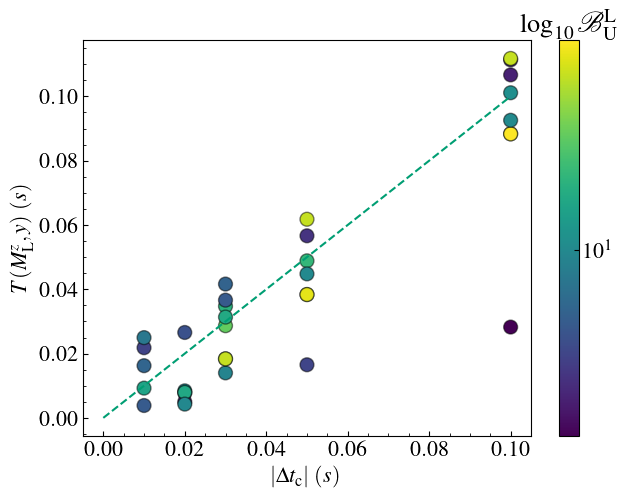

In [34]:
fig, ax = plt.subplots()
linthresh, linscale = 1e-2, 1.0
ts = np.minimum(time_delays, 4-time_delays)
sc = ax.scatter(np.abs(delta_tc), ts, c=log_bayes_factor_ml_diff, cmap=color_palette['colormap'], edgecolor=(0, 0, 0, 0.5), s=100, norm=SymLogNorm(
        linthresh=linthresh,
        linscale=linscale,
        vmin=np.nanmin(log_bayes_factor_ml_diff[log_bayes_factor_ml_diff > 0.5]),
        vmax=np.nanmax(log_bayes_factor_ml_diff[log_bayes_factor_ml_diff > 0.5]),
        base=10
    ))
x = np.linspace(0, 0.1, 100)
ax.plot(x, x, color=color_palette['tertiary'], linestyle='--')
clb = fig.colorbar(sc, ax=ax)
clb.ax.set_title('$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U}$')
ax.set_xlabel('$|\\Delta t_{\\rm c}|\\ (s)$')
ax.set_ylabel('$T(M_{\\rm L}^z,y)\\ (s)$')
plt.tight_layout()
plt.savefig('../../output/pe_population/output/MicrolensedTimeDelay.pdf', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

### Cummulative Plots & Comparisions

In [14]:
bias_mchirp_a_ml = np.abs(mchirp_ml-mchirp_a)/mchirp_a*100
bias_mchirp_b_ml = np.abs(mchirp_ml-mchirp_b)/mchirp_b*100

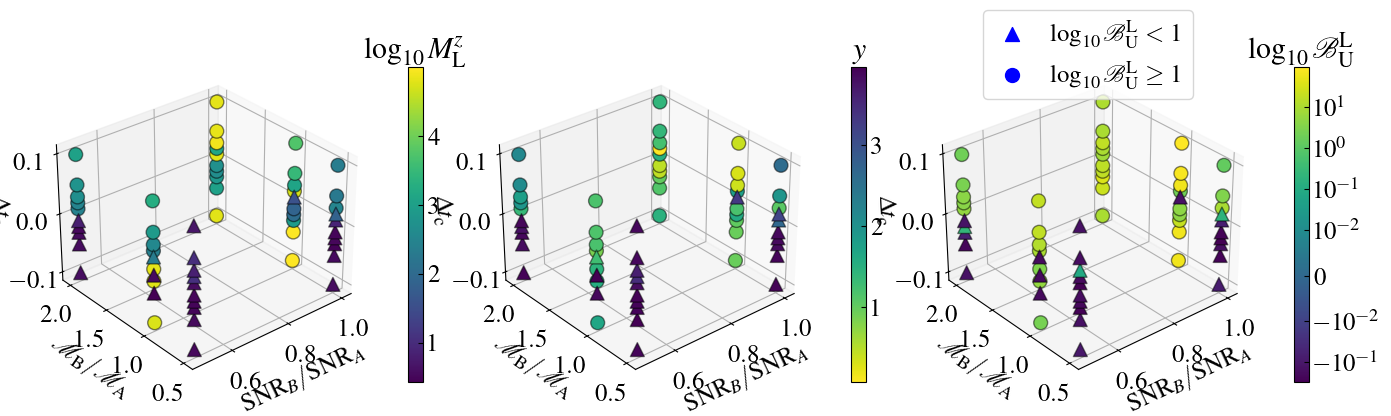

In [15]:
plt.rcParams.update(new_rcParams(width='page'))
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'})

diff_greater_1 = np.where(log_bayes_factor_ml_diff >= 1)
diff_lesser_1 = np.where(log_bayes_factor_ml_diff < 1)

scatter1 = axes[0].scatter(snr_b[diff_greater_1]/snr_a[diff_greater_1], mchirp_b[diff_greater_1]/mchirp_a[diff_greater_1], delta_tc[diff_greater_1], c=np.log10(Mlz_recovered[diff_greater_1]), edgecolor=(0, 0, 0, 0.5), cmap=color_palette['colormap'], s=100, depthshade=False,  marker='o', vmin=np.nanmin(np.log10(Mlz_recovered)), vmax=np.nanmax(np.log10(Mlz_recovered)))
scatter1b = axes[0].scatter(snr_b[diff_lesser_1]/snr_a[diff_lesser_1], mchirp_b[diff_lesser_1]/mchirp_a[diff_lesser_1], delta_tc[diff_lesser_1], c=np.log10(Mlz_recovered[diff_lesser_1]), edgecolor=(0, 0, 0, 0.5), cmap=color_palette['colormap'], s=100, depthshade=False,  marker='^', vmin=np.nanmin(np.log10(Mlz_recovered)), vmax=np.nanmax(np.log10(Mlz_recovered)))
clb1 = fig.colorbar(scatter1, ax=axes[0], shrink=0.7, pad=0.1)
clb1.ax.set_title('$\\log_{10} M_{\\rm L}^z$')

axes[0].set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$')
axes[0].set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[0].set_zlabel('$\\Delta t_{\\rm c}$')
#axes[0].set_title('Redshifted Lens Mass $M_{\\rm L}^z$ values', loc='center')
axes[0].ticklabel_format(useOffset=False, style='plain')
axes[0].azim = 230

scatter2 = axes[1].scatter(snr_b[diff_greater_1]/snr_a[diff_greater_1], mchirp_b[diff_greater_1]/mchirp_a[diff_greater_1], delta_tc[diff_greater_1], c=yl_recovered[diff_greater_1], edgecolor=(0, 0, 0, 0.5), cmap='viridis_r', s=100, depthshade=False, marker='o', vmin=np.nanmin(yl_recovered), vmax=np.nanmax(yl_recovered))
scatter2b = axes[1].scatter(snr_b[diff_lesser_1]/snr_a[diff_lesser_1], mchirp_b[diff_lesser_1]/mchirp_a[diff_lesser_1], delta_tc[diff_lesser_1], c=yl_recovered[diff_lesser_1], edgecolor=(0, 0, 0, 0.5), cmap='viridis_r', s=100, depthshade=False, marker='^', vmin=np.nanmin(yl_recovered), vmax=np.nanmax(yl_recovered))
clb2 = fig.colorbar(scatter2, ax=axes[1], shrink=0.7, pad=0.1)
clb2.ax.set_title('$y$')

axes[1].set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$')
axes[1].set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[1].set_zlabel('$\\Delta t_{\\rm c}$')
#axes[1].set_title('Impact Parameter $y$ values', loc='center')
axes[1].ticklabel_format(useOffset=False, style='plain')
axes[1].azim = 230

linthresh, linscale = 1e-2, 1.0

scatter3 = axes[2].scatter(
    snr_b[diff_greater_1]/snr_a[diff_greater_1],
    mchirp_b[diff_greater_1]/mchirp_a[diff_greater_1],
    delta_tc[diff_greater_1],
    c=log_bayes_factor_ml_diff[diff_greater_1],
    edgecolor=(0, 0, 0, 0.5),
    cmap=color_palette['colormap'],
    s=100,
    depthshade=False,
    marker='o',
    norm=SymLogNorm(
        linthresh=linthresh,
        linscale=linscale,
        vmin=np.nanmin(log_bayes_factor_ml_diff),
        vmax=np.nanmax(log_bayes_factor_ml_diff),
        base=10
    )
)

scatter3b = axes[2].scatter(
    snr_b[diff_lesser_1]/snr_a[diff_lesser_1],
    mchirp_b[diff_lesser_1]/mchirp_a[diff_lesser_1],
    delta_tc[diff_lesser_1],
    c=log_bayes_factor_ml_diff[diff_lesser_1],
    edgecolor=(0, 0, 0, 0.5),
    cmap=color_palette['colormap'],
    s=100,
    depthshade=False,
    marker='^',
    norm=SymLogNorm(
        linthresh=linthresh,
        linscale=linscale,
        vmin=np.nanmin(log_bayes_factor_ml_diff),
        vmax=np.nanmax(log_bayes_factor_ml_diff),
        base=10
    )
)

clb3 = fig.colorbar(scatter3, ax=axes[2], shrink=0.7, pad=0.1)
clb3.ax.set_title('$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U}$')

axes[2].scatter([], [], c='b', s=100, marker='^', label='$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U} < 1$')
axes[2].scatter([], [], c='b', s=100, marker='o', label='$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U} \\geq 1$')
axes[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))

axes[2].set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$')
axes[2].set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[2].set_zlabel('$\\Delta t_{\\rm c}$')
#axes[2].set_title('Recovered $\\log_{10}\\mathscr{B}_{\\mathrm{ML}}-\\log_{10}\\mathscr{B}_{0}$ values', loc='center')
axes[2].ticklabel_format(useOffset=False, style='plain')
axes[2].azim = 230

plt.tight_layout()
plt.savefig('../../output/pe_population/output/MicrolensedRecoveryParameters.pdf', dpi=600, bbox_inches='tight')
plt.show()

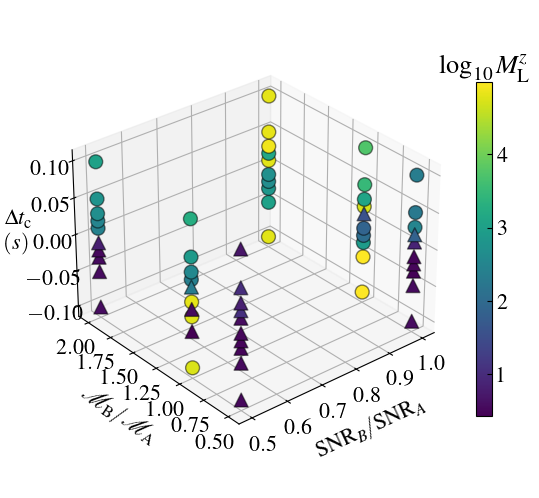

In [16]:
plt.rcParams.update(new_rcParams())
fig, axes = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

scattera = axes.scatter(snr_b[diff_greater_1]/snr_a[diff_greater_1], mchirp_b[diff_greater_1]/mchirp_a[diff_greater_1], delta_tc[diff_greater_1], c=np.log10(Mlz_recovered[diff_greater_1]), edgecolor=(0, 0, 0, 0.5), cmap=color_palette['colormap'], s=100, depthshade=False,  marker='o', vmin=np.nanmin(np.log10(Mlz_recovered)), vmax=np.nanmax(np.log10(Mlz_recovered)))
scatterb = axes.scatter(snr_b[diff_lesser_1]/snr_a[diff_lesser_1], mchirp_b[diff_lesser_1]/mchirp_a[diff_lesser_1], delta_tc[diff_lesser_1], c=np.log10(Mlz_recovered[diff_lesser_1]), edgecolor=(0, 0, 0, 0.5), cmap=color_palette['colormap'], s=100, depthshade=False,  marker='^', vmin=np.nanmin(np.log10(Mlz_recovered)), vmax=np.nanmax(np.log10(Mlz_recovered)))
axes.set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$', labelpad=12)
axes.set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$', labelpad=12)
axes.zaxis.set_rotate_label(False)
axes.set_zlabel('$\\Delta t_{\\rm c}$\n$(s)$', labelpad=8) 
axes.ticklabel_format(useOffset=False, style='plain')
axes.azim = 230
axes.set_box_aspect(None, zoom=0.835)

clb = fig.colorbar(scattera, ax=axes, shrink=0.7, pad=-0.02)
clb.ax.set_title('$\\log_{10} M_{\\rm L}^z$')

plt.tight_layout()

plt.savefig('../../output/pe_population/output/MicrolensedRecoveryParameters1.pdf', dpi=600, bbox_inches='tight')
plt.show()

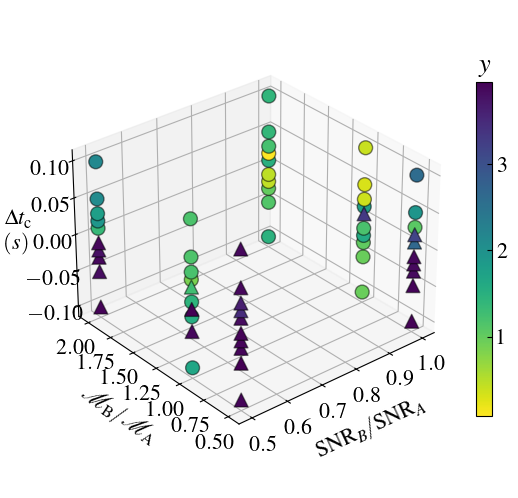

In [17]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

scattera = axes.scatter(snr_b[diff_greater_1]/snr_a[diff_greater_1], mchirp_b[diff_greater_1]/mchirp_a[diff_greater_1], delta_tc[diff_greater_1], c=yl_recovered[diff_greater_1], edgecolor=(0, 0, 0, 0.5), cmap='viridis_r', s=100, depthshade=False, marker='o', vmin=np.nanmin(yl_recovered), vmax=np.nanmax(yl_recovered))
scatterb = axes.scatter(snr_b[diff_lesser_1]/snr_a[diff_lesser_1], mchirp_b[diff_lesser_1]/mchirp_a[diff_lesser_1], delta_tc[diff_lesser_1], c=yl_recovered[diff_lesser_1], edgecolor=(0, 0, 0, 0.5), cmap='viridis_r', s=100, depthshade=False, marker='^', vmin=np.nanmin(yl_recovered), vmax=np.nanmax(yl_recovered))
axes.set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$', labelpad=12)
axes.set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$', labelpad=12)
axes.zaxis.set_rotate_label(False)
axes.set_zlabel('$\\Delta t_{\\rm c}$\n$(s)$', labelpad=8) 
axes.ticklabel_format(useOffset=False, style='plain')
axes.azim = 230
axes.set_box_aspect(None, zoom=0.835)

clb = fig.colorbar(scattera, ax=axes, shrink=0.7, pad=-0.02)
clb.ax.set_title('$y$')

plt.tight_layout()

plt.savefig('../../output/pe_population/output/MicrolensedRecoveryParameters2.pdf', dpi=600, bbox_inches='tight')
plt.show()

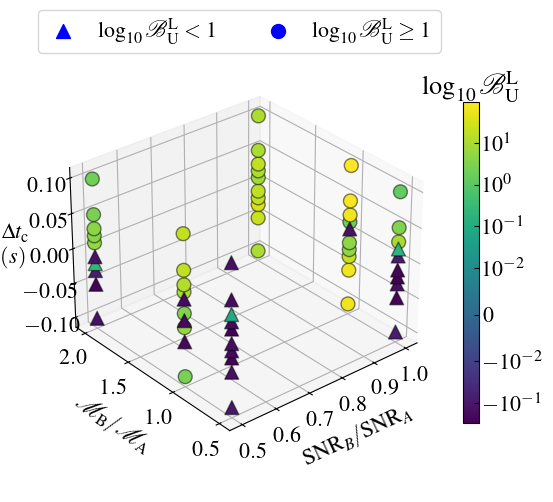

In [18]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

linthresh, linscale = 1e-2, 1.0

scatter3 = axes.scatter(
    snr_b[diff_greater_1]/snr_a[diff_greater_1],
    mchirp_b[diff_greater_1]/mchirp_a[diff_greater_1],
    delta_tc[diff_greater_1],
    c=log_bayes_factor_ml_diff[diff_greater_1],
    edgecolor=(0, 0, 0, 0.5),
    cmap=color_palette['colormap'],
    s=100,
    depthshade=False,
    marker='o',
    norm=SymLogNorm(
        linthresh=linthresh,
        linscale=linscale,
        vmin=np.nanmin(log_bayes_factor_ml_diff),
        vmax=np.nanmax(log_bayes_factor_ml_diff),
        base=10
    )
)

scatter3b = axes.scatter(
    snr_b[diff_lesser_1]/snr_a[diff_lesser_1],
    mchirp_b[diff_lesser_1]/mchirp_a[diff_lesser_1],
    delta_tc[diff_lesser_1],
    c=log_bayes_factor_ml_diff[diff_lesser_1],
    edgecolor=(0, 0, 0, 0.5),
    cmap=color_palette['colormap'],
    s=100,
    depthshade=False,
    marker='^',
    norm=SymLogNorm(
        linthresh=linthresh,
        linscale=linscale,
        vmin=np.nanmin(log_bayes_factor_ml_diff),
        vmax=np.nanmax(log_bayes_factor_ml_diff),
        base=10
    )
)

clb3 = fig.colorbar(scatter3, ax=axes, shrink=0.7, pad=-0.01)
clb3.ax.set_title('$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U}$')

axes.scatter([], [], c='b', s=100, marker='^', label='$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U} < 1$')
axes.scatter([], [], c='b', s=100, marker='o', label='$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U} \\geq 1$')
axes.legend(loc='upper center', ncols=2, bbox_to_anchor=(0.5, 1.075))
axes.set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$', labelpad=12)
axes.set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$', labelpad=12)
axes.zaxis.set_rotate_label(False)
axes.set_zlabel('$\\Delta t_{\\rm c}$\n$(s)$', labelpad=8) 
axes.ticklabel_format(useOffset=False, style='plain')
axes.azim = 230
axes.set_box_aspect(None, zoom=0.835)

plt.tight_layout()

plt.savefig('../../output/pe_population/output/MicrolensedRecoveryParameters3.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [19]:
# for i in range(len(combinations)):
#     try:
#         fs_pe = glob('../../output/pe_population/final_result/PE_{}_{}_{}/*'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#         fs_pe_ml = glob('../../output/pe_population/final_result/PE_ML_{}_{}_{}/*'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
        
#         result_pe = bilby.result.read_in_result(filename=fs_pe[0])
#         result_pe_ml = bilby.result.read_in_result(filename=fs_pe_ml[0])
#     except:
#         continue

#     plot1 = bilby.core.result.plot_multiple(
#         [result_pe, result_pe_ml], labels=['Unlensed', 'Microlensed'], save=False, parameters=["chirp_mass", "mass_ratio"],
#     )
#     plot1.axes[0].axvline(mchirp_a[i], color='r', linestyle='--')
#     plot1.axes[0].axvline(mchirp_b[i], color='m', linestyle='--')
#     plot1.axes[3].axvline(q_a[i], color='r', linestyle='--')
#     plot1.axes[3].axvline(q_b[i], color='m', linestyle='--')
#     plot1.axes[1].text(0.5, 0.5, '$\\mathscr{{M}}_A={}$\n$\\mathscr{{M}}_B={}$\n$q_A={}$\n$q_B={}$'.format(round(mchirp_a[i],2), round(mchirp_b[i],2), round(q_a[i],2), round(q_b[i], 2)), horizontalalignment='center', verticalalignment='center', transform=plot1.axes[1].transAxes)
#     plot1.suptitle('$\\mathrm{{SNR}}_{{\\rm A}}/\\mathrm{{SNR}}_{{\\rm B}}={}$\n$\\mathscr{{M}}_A/\\mathscr{{M}}_B={}\ \\&\ \\Delta t_{\\rm c}={}$'.format(round(snr_a[i]/snr_b[i],2), round(mchirp_a[i]/mchirp_b[i],2), round(delta_tc[i],3)))
#     plot1.set_size_inches(8, 8)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/comparisions/Mq_PE_PE_ML_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()

#     plot2 = bilby.core.result.plot_multiple(
#         [result_pe, result_pe_ml], labels=['Unlensed', 'Microlensed'], save=False, parameters=["mass_1", "mass_2"],
#     )
#     plot2.axes[0].axvline(data_a[i]['mass_1'], color='r', linestyle='--')
#     plot2.axes[0].axvline(data_b[i]['mass_1'], color='m', linestyle='--')
#     plot2.axes[3].axvline(data_a[i]['mass_2'], color='r', linestyle='--')
#     plot2.axes[3].axvline(data_b[i]['mass_2'], color='m', linestyle='--')
#     plot2.axes[1].text(0.5, 0.5, '$m_{{1A}}={}$\n$m_{{1B}}={}$\n$m_{{2A}}={}$\n$m_{{2B}}={}$'.format(round(data_a[i]['mass_1'],2), round(data_b[i]['mass_1'],2), round(data_a[i]['mass_2'],2), round(data_b[i]['mass_2'], 2)), horizontalalignment='center', verticalalignment='center', transform=plot2.axes[1].transAxes)
#     plot2.suptitle('$\\mathrm{{SNR}}_{{\\rm A}}/\\mathrm{{SNR}}_{{\\rm B}}={}$\n$\\mathscr{{M}}_A/\\mathscr{{M}}_B={}\ \\&\ \\Delta t_{\\rm c}={}$'.format(round(snr_a[i]/snr_b[i],2), round(mchirp_a[i]/mchirp_b[i],2), round(delta_tc[i],3)))
#     plot2.set_size_inches(8, 8)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/comparisions/m1m2_PE_PE_ML_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()

### Type II Lensed

In [20]:
mchirp_ml2, log_bayes_factor_ml2 = np.zeros(len(combinations)), np.zeros(len(combinations))
for i in range(len(combinations)):
    fs = glob('../../output/pe_population/final_result/PE_ML2_{}_{}_{}/*'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
    result = bilby.result.read_in_result(filename=fs[0])
    mchirp_ml2[i] = result.posterior['chirp_mass'].median()
    log_bayes_factor_ml2[i] = result.log_10_bayes_factor
    
log_bayes_factor_ml2_diff = log_bayes_factor_ml2-log_bayes_factor

10:48 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for legacy decoding will be removed in a future release.
10:48 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:48 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for legacy decoding will be removed in a future release.
10:48 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:48 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for leg

In [21]:
# for i in range(len(combinations)):
#     fs = glob('../../output/pe_population/final_result/PE_ML2_{}_{}_{}/*'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     result = bilby.result.read_in_result(filename=fs[0])

#     plot1 = result.plot_{\\rm c}orner(
#         parameters=["chirp_mass", "mass_ratio"], save=False
#     )
#     plot1.axes[0].axvline(mchirp_a[i], color='r', linestyle='--')
#     plot1.axes[0].axvline(mchirp_b[i], color='m', linestyle='--')
#     plot1.axes[3].axvline(q_a[i], color='r', linestyle='--')
#     plot1.axes[3].axvline(q_b[i], color='m', linestyle='--')
#     plot1.axes[1].text(0.5, 0.5, '$\\mathscr{{M}}_A={}$\n$\\mathscr{{M}}_B={}$\n$q_A={}$\n$q_B={}$'.format(round(mchirp_a[i],2), round(mchirp_b[i],2), round(q_a[i],2), round(q_b[i], 2)), horizontalalignment='center', verticalalignment='center', transform=plot1.axes[1].transAxes)
#     plot1.suptitle('$\\mathrm{{SNR}}_{{\\rm A}}/\\mathrm{{SNR}}_{{\\rm B}}={}$\n$\\mathscr{{M}}_A/\\mathscr{{M}}_B={}\ \\&\ \\Delta t_{\\rm c}={}$'.format(round(snr_a[i]/snr_b[i],2), round(mchirp_a[i]/mchirp_b[i],2), round(delta_tc[i],3)))
#     plot1.set_size_inches(8, 8)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/pe_ml2/Mq_PE_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()
    
#     plot2 = result.plot_{\\rm c}orner(
#         parameters=["mass_1", "mass_2"], save=False
#     )
#     plot2.axes[0].axvline(data_a[i]['mass_1'], color='r', linestyle='--')
#     plot2.axes[0].axvline(data_b[i]['mass_1'], color='m', linestyle='--')
#     plot2.axes[3].axvline(data_a[i]['mass_2'], color='r', linestyle='--')
#     plot2.axes[3].axvline(data_b[i]['mass_2'], color='m', linestyle='--')
#     plot2.axes[1].text(0.5, 0.5, '$m_{{1A}}={}$\n$m_{{1B}}={}$\n$m_{{2A}}={}$\n$m_{{2B}}={}$'.format(round(data_a[i]['mass_1'],2), round(data_b[i]['mass_1'],2), round(data_a[i]['mass_2'],2), round(data_b[i]['mass_2'], 2)), horizontalalignment='center', verticalalignment='center', transform=plot2.axes[1].transAxes)
#     plot2.suptitle('$\\mathrm{{SNR}}_{{\\rm A}}/\\mathrm{{SNR}}_{{\\rm B}}={}$\n$\\mathscr{{M}}_A/\\mathscr{{M}}_B={}\ \\&\ \\Delta t_{\\rm c}={}$'.format(round(snr_a[i]/snr_b[i],2), round(mchirp_a[i]/mchirp_b[i],2), round(delta_tc[i],3)))
#     plot2.set_size_inches(8, 8)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/pe_ml2/m1m2_PE_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()

### Type II Lensed (C)

In [ ]:
mchirp_ml2c, log_bayes_factor_ml2c, n_ml2c, np_ml2c = np.zeros(len(combinations)), np.zeros(len(combinations)), np.zeros(len(combinations)), np.zeros(len(combinations))
for i in range(len(combinations)):
    fs = glob('../../output/pe_population/final_result/PE_ML2C_{}_{}_{}/*'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
    result = bilby.result.read_in_result(filename=fs[0])
    idx_max = np.argmax(result.posterior["log_likelihood"])
    np_ml2c[i] = (result.posterior['imagetype'][idx_max]-1)/2
    mchirp_ml2c[i] = result.posterior['chirp_mass'].median()
    log_bayes_factor_ml2c[i] = result.log_10_bayes_factor
    
log_bayes_factor_ml2c_diff = log_bayes_factor_ml2c-log_bayes_factor

10:48 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for legacy decoding will be removed in a future release.
10:48 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:48 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for legacy decoding will be removed in a future release.
10:48 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
10:48 bilby WARNING : Failed to decode cosmology, falling back to legacy decoding. Support for leg

In [23]:
# for i in range(len(combinations)):
#     fs = glob('../../output/pe_population/final_result/PE_ML2C_{}_{}_{}/*'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     result = bilby.result.read_in_result(filename=fs[0])

#     plot1 = result.plot_{\\rm c}orner(
#         parameters=["chirp_mass", "mass_ratio"], save=False
#     )
#     plot1.axes[0].axvline(mchirp_a[i], color='r', linestyle='--')
#     plot1.axes[0].axvline(mchirp_b[i], color='m', linestyle='--')
#     plot1.axes[3].axvline(q_a[i], color='r', linestyle='--')
#     plot1.axes[3].axvline(q_b[i], color='m', linestyle='--')
#     plot1.axes[1].text(0.5, 0.5, '$\\mathscr{{M}}_A={}$\n$\\mathscr{{M}}_B={}$\n$q_A={}$\n$q_B={}$'.format(round(mchirp_a[i],2), round(mchirp_b[i],2), round(q_a[i],2), round(q_b[i], 2)), horizontalalignment='center', verticalalignment='center', transform=plot1.axes[1].transAxes)
#     plot1.suptitle('$\\mathrm{{SNR}}_{{\\rm A}}/\\mathrm{{SNR}}_{{\\rm B}}={}$\n$\\mathscr{{M}}_A/\\mathscr{{M}}_B={}\ \\&\ \\Delta t_{\\rm c}={}$'.format(round(snr_a[i]/snr_b[i],2), round(mchirp_a[i]/mchirp_b[i],2), round(delta_tc[i],3)))
#     plot1.set_size_inches(8, 8)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/pe_ml2c/Mq_PE_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()
    
#     plot2 = result.plot_{\\rm c}orner(
#         parameters=["mass_1", "mass_2"], save=False
#     )
#     plot2.axes[0].axvline(data_a[i]['mass_1'], color='r', linestyle='--')
#     plot2.axes[0].axvline(data_b[i]['mass_1'], color='m', linestyle='--')
#     plot2.axes[3].axvline(data_a[i]['mass_2'], color='r', linestyle='--')
#     plot2.axes[3].axvline(data_b[i]['mass_2'], color='m', linestyle='--')
#     plot2.axes[1].text(0.5, 0.5, '$m_{{1A}}={}$\n$m_{{1B}}={}$\n$m_{{2A}}={}$\n$m_{{2B}}={}$'.format(round(data_a[i]['mass_1'],2), round(data_b[i]['mass_1'],2), round(data_a[i]['mass_2'],2), round(data_b[i]['mass_2'], 2)), horizontalalignment='center', verticalalignment='center', transform=plot2.axes[1].transAxes)
#     plot2.suptitle('$\\mathrm{{SNR}}_{{\\rm A}}/\\mathrm{{SNR}}_{{\\rm B}}={}$\n$\\mathscr{{M}}_A/\\mathscr{{M}}_B={}\ \\&\ \\Delta t_{\\rm c}={}$'.format(round(snr_a[i]/snr_b[i],2), round(mchirp_a[i]/mchirp_b[i],2), round(delta_tc[i],3)))
#     plot2.set_size_inches(8, 8)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/pe_ml2c/m1m2_PE_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()

#     plot3 = result.plot_{\\rm c}orner(
#         parameters=["imagetype"], save=False
#     )
#     plot3.axes[0].axvline(2*n_ml2c[i]+2, color='r', linestyle='--')
#     plot3.suptitle('$2(n_j+1)={}$'.format(n_ml2c[i]))
#     plot3.set_size_inches(8, 8)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/pe_ml2c/n_PE_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()

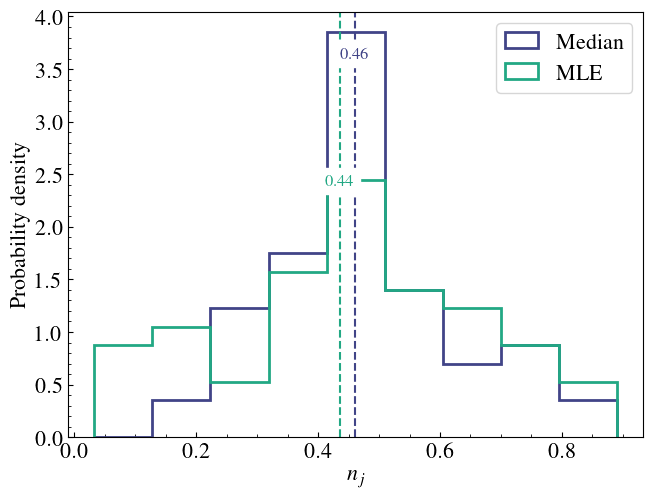

In [35]:
fig, ax = plt.subplots()
cmap = plt.get_cmap(color_palette['colormap'])

all_samples = np.hstack([n_ml2c[~np.isnan(n_ml2c)], np_ml2c[~np.isnan(np_ml2c)]])
bins = np.linspace(np.nanmin(all_samples), np.nanmax(all_samples), 10)

ax.hist(n_ml2c, bins=bins, density=True, histtype='step', linewidth=2, label='Median', color=cmap(0.2))
ax.hist(np_ml2c, bins=bins, density=True, histtype='step', linewidth=2, label='MLE', color=cmap(0.6))

vmed = np.nanmedian(n_ml2c)
vmap = np.nanmedian(np_ml2c)
ax.axvline(vmed, color=cmap(0.2), linestyle='--', lw=1.5)
ax.axvline(vmap, color=cmap(0.6), linestyle='--', lw=1.5)
ax.text(vmed, ax.get_ylim()[1]*0.92, f'{vmed:.2f}', color=cmap(0.2),
        ha='center', va='top', fontsize=12, backgroundcolor='white')
ax.text(vmap, ax.get_ylim()[1]*0.62, f'{vmap:.2f}', color=cmap(0.6),
        ha='center', va='top', fontsize=12, backgroundcolor='white')

ax.set_xlabel(r'$n_j$')
ax.set_ylabel('Probability density')
ax.legend()
ax.grid(False)
plt.tight_layout()
plt.savefig('../../output/pe_population/output/TypeIILensedRecoveryParametersHist.pdf')
plt.show()

### Cummulative Plots & Comparisions

In [24]:
bias_mchirp_a_ml2c = np.abs(mchirp_ml2c-mchirp_a)/mchirp_a*100
bias_mchirp_b_ml2c = np.abs(mchirp_ml2c-mchirp_b)/mchirp_b*100

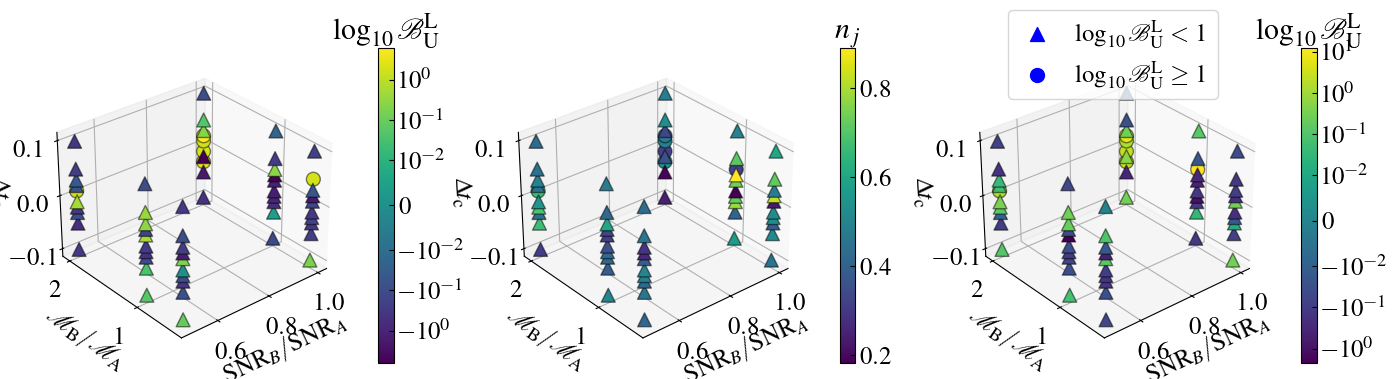

In [25]:
plt.rcParams.update(new_rcParams(width='page'))
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'})

diff_greater_1 = np.where(log_bayes_factor_ml2_diff >= 1)[0]
diff_lesser_1 = np.where(log_bayes_factor_ml2_diff < 1)[0]

scatter3 = axes[0].scatter(
    snr_b[diff_greater_1]/snr_a[diff_greater_1],
    mchirp_b[diff_greater_1]/mchirp_a[diff_greater_1],
    delta_tc[diff_greater_1],
    c=log_bayes_factor_ml2_diff[diff_greater_1],
    edgecolor=(0, 0, 0, 0.5),
    cmap=color_palette['colormap'],
    s=100,
    depthshade=False,
    marker='o',
    norm=SymLogNorm(
        linthresh=linthresh,
        linscale=linscale,
        vmin=np.nanmin(log_bayes_factor_ml2_diff),
        vmax=np.nanmax(log_bayes_factor_ml2_diff),
        base=10
    )
)

scatter5 = axes[0].scatter(
    snr_b[diff_lesser_1]/snr_a[diff_lesser_1],
    mchirp_b[diff_lesser_1]/mchirp_a[diff_lesser_1],
    delta_tc[diff_lesser_1],
    c=log_bayes_factor_ml2_diff[diff_lesser_1],
    edgecolor=(0, 0, 0, 0.5),
    cmap=color_palette['colormap'],
    s=100,
    depthshade=False,
    marker='^',
    norm=SymLogNorm(
        linthresh=linthresh,
        linscale=linscale,
        vmin=np.nanmin(log_bayes_factor_ml2_diff),
        vmax=np.nanmax(log_bayes_factor_ml2_diff),
        base=10
    )
)

clb3 = fig.colorbar(scatter3, ax=axes[0], shrink=0.7, pad=0.1)
clb3.ax.set_title('$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U}$')

axes[0].set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$')
axes[0].set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[0].set_zlabel('$\\Delta t_{\\rm c}$')
#axes[0].set_title('Recovered $\\log_{10}\\mathscr{B}_{\\mathrm{L}}-\\log_{10}\\mathscr{B}_{0}$ values', loc='center')
axes[0].ticklabel_format(useOffset=False, style='plain')
axes[0].azim = 230

diff_greater_1 = np.where(log_bayes_factor_ml2c_diff >= 1)[0]
diff_lesser_1 = np.where(log_bayes_factor_ml2c_diff < 1)[0]

scatter2 = axes[1].scatter(snr_b[diff_greater_1]/snr_a[diff_greater_1], mchirp_b[diff_greater_1]/mchirp_a[diff_greater_1], delta_tc[diff_greater_1], c=n_ml2c[diff_greater_1], edgecolor=(0, 0, 0, 0.5), cmap='viridis', s=100, depthshade=False, marker='o', vmin=np.nanmin(n_ml2c), vmax=np.nanmax(n_ml2c))
scatter2b = axes[1].scatter(snr_b[diff_lesser_1]/snr_a[diff_lesser_1], mchirp_b[diff_lesser_1]/mchirp_a[diff_lesser_1], delta_tc[diff_lesser_1], c=n_ml2c[diff_lesser_1], edgecolor=(0, 0, 0, 0.5), cmap='viridis', s=100, depthshade=False, marker='^', vmin=np.nanmin(n_ml2c), vmax=np.nanmax(n_ml2c))
clb2 = fig.colorbar(scatter2, ax=axes[1], shrink=0.7, pad=0.1)
clb2.ax.set_title('$n_j$')
clb2.ax.ticklabel_format(useOffset=False, style='plain')

axes[1].set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$')
axes[1].set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[1].set_zlabel('$\\Delta t_{\\rm c}$')
#axes[1].set_title('Morse Index $n_j$ values', loc='center')
axes[1].ticklabel_format(useOffset=False, style='plain')
axes[1].azim = 230

scatter6 = axes[2].scatter(
    snr_b[diff_greater_1]/snr_a[diff_greater_1],
    mchirp_b[diff_greater_1]/mchirp_a[diff_greater_1],
    delta_tc[diff_greater_1],
    c=log_bayes_factor_ml2c_diff[diff_greater_1],
    edgecolor=(0, 0, 0, 0.5),
    cmap=color_palette['colormap'],
    s=100,
    depthshade=False,
    marker='o',
    norm=SymLogNorm(
        linthresh=linthresh,
        linscale=linscale,
        vmin=np.nanmin(log_bayes_factor_ml2c_diff),
        vmax=np.nanmax(log_bayes_factor_ml2c_diff),
        base=10
    )
)

scatter8 = axes[2].scatter(
    snr_b[diff_lesser_1]/snr_a[diff_lesser_1],
    mchirp_b[diff_lesser_1]/mchirp_a[diff_lesser_1],
    delta_tc[diff_lesser_1],
    c=log_bayes_factor_ml2c_diff[diff_lesser_1],
    edgecolor=(0, 0, 0, 0.5),
    cmap=color_palette['colormap'],
    s=100,
    depthshade=False,
    marker='^',
    norm=SymLogNorm(
        linthresh=linthresh,
        linscale=linscale,
        vmin=np.nanmin(log_bayes_factor_ml2c_diff),
        vmax=np.nanmax(log_bayes_factor_ml2c_diff),
        base=10
    )
)

clb3 = fig.colorbar(scatter6, ax=axes[2], shrink=0.7, pad=0.1)
clb3.ax.set_title('$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U}$')

axes[2].scatter([], [], c='b', s=100, marker='^', label='$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U} < 1$')
axes[2].scatter([], [], c='b', s=100, marker='o', label='$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U} \\geq 1$')
axes[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))

axes[2].set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$')
axes[2].set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[2].set_zlabel('$\\Delta t_{\\rm c}$')
#axes[2].set_title('Recovered $\\log_{10}\\mathscr{B}_{\\mathrm{L}}-\\log_{10}\\mathscr{B}_{0}$ values', loc='center')
axes[2].ticklabel_format(useOffset=False, style='plain')
axes[2].azim = 230

plt.tight_layout()
plt.savefig('../../output/pe_population/output/TypeIILensedPE.pdf', dpi=600, bbox_inches='tight')
plt.show()

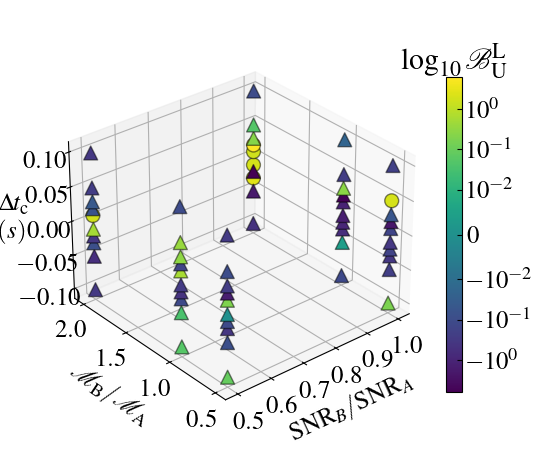

In [26]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

linthresh, linscale = 1e-2, 1.0

diff_greater_1 = np.where(log_bayes_factor_ml2_diff >= 1)[0]
diff_lesser_1 = np.where(log_bayes_factor_ml2_diff < 1)[0]

scatter3 = axes.scatter(
    snr_b[diff_greater_1]/snr_a[diff_greater_1],
    mchirp_b[diff_greater_1]/mchirp_a[diff_greater_1],
    delta_tc[diff_greater_1],
    c=log_bayes_factor_ml2_diff[diff_greater_1],
    edgecolor=(0, 0, 0, 0.5),
    cmap=color_palette['colormap'],
    s=100,
    depthshade=False,
    marker='o',
    norm=SymLogNorm(
        linthresh=linthresh,
        linscale=linscale,
        vmin=np.nanmin(log_bayes_factor_ml2_diff),
        vmax=np.nanmax(log_bayes_factor_ml2_diff),
        base=10
    )
)

scatter3b = axes.scatter(
    snr_b[diff_lesser_1]/snr_a[diff_lesser_1],
    mchirp_b[diff_lesser_1]/mchirp_a[diff_lesser_1],
    delta_tc[diff_lesser_1],
    c=log_bayes_factor_ml2_diff[diff_lesser_1],
    edgecolor=(0, 0, 0, 0.5),
    cmap=color_palette['colormap'],
    s=100,
    depthshade=False,
    marker='^',
    norm=SymLogNorm(
        linthresh=linthresh,
        linscale=linscale,
        vmin=np.nanmin(log_bayes_factor_ml2_diff),
        vmax=np.nanmax(log_bayes_factor_ml2_diff),
        base=10
    )
)

clb3 = fig.colorbar(scatter3, ax=axes, shrink=0.7, pad=-0.01)
clb3.ax.set_title('$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U}$')

axes.set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$', labelpad=12)
axes.set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$', labelpad=12)
axes.zaxis.set_rotate_label(False)
axes.set_zlabel('$\\Delta t_{\\rm c}$\n$(s)$', labelpad=8) 
axes.ticklabel_format(useOffset=False, style='plain')
axes.azim = 230
axes.set_box_aspect(None, zoom=0.835)

plt.tight_layout()

plt.savefig('../../output/pe_population/output/TypeIILensedPE1.pdf', dpi=600, bbox_inches='tight')
plt.show()

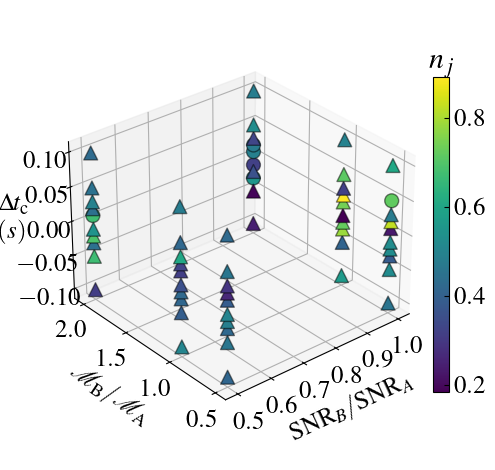

In [27]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

scattera = axes.scatter(snr_b[diff_greater_1]/snr_a[diff_greater_1], mchirp_b[diff_greater_1]/mchirp_a[diff_greater_1], delta_tc[diff_greater_1], c=n_ml2c[diff_greater_1], edgecolor=(0, 0, 0, 0.5), cmap='viridis', s=100, depthshade=False, marker='o', vmin=np.nanmin(n_ml2c), vmax=np.nanmax(n_ml2c))
scatterb = axes.scatter(snr_b[diff_lesser_1]/snr_a[diff_lesser_1], mchirp_b[diff_lesser_1]/mchirp_a[diff_lesser_1], delta_tc[diff_lesser_1], c=n_ml2c[diff_lesser_1], edgecolor=(0, 0, 0, 0.5), cmap='viridis', s=100, depthshade=False, marker='^', vmin=np.nanmin(n_ml2c), vmax=np.nanmax(n_ml2c))
axes.set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$', labelpad=12)
axes.set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$', labelpad=12)
axes.zaxis.set_rotate_label(False)
axes.set_zlabel('$\\Delta t_{\\rm c}$\n$(s)$', labelpad=8) 
axes.ticklabel_format(useOffset=False, style='plain')
axes.azim = 230
axes.set_box_aspect(None, zoom=0.835)

clb = fig.colorbar(scattera, ax=axes, shrink=0.7, pad=-0.02)
clb.ax.set_title('$n_j$')

plt.tight_layout()

plt.savefig('../../output/pe_population/output/TypeIILensedPE2.pdf', dpi=600, bbox_inches='tight')
plt.show()

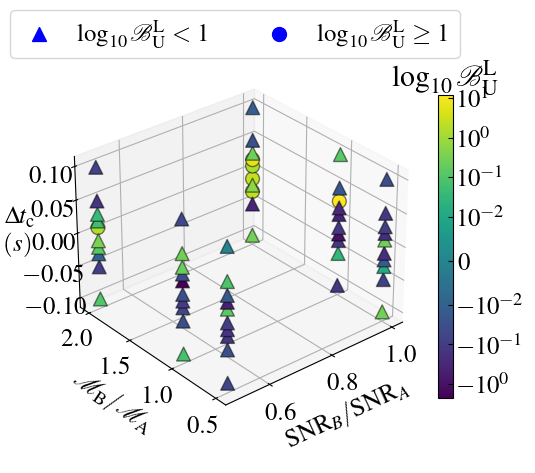

In [28]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

diff_greater_1 = np.where(log_bayes_factor_ml2c_diff >= 1)[0]
diff_lesser_1 = np.where(log_bayes_factor_ml2c_diff < 1)[0]

linthresh, linscale = 1e-2, 1.0

scatter3 = axes.scatter(
    snr_b[diff_greater_1]/snr_a[diff_greater_1],
    mchirp_b[diff_greater_1]/mchirp_a[diff_greater_1],
    delta_tc[diff_greater_1],
    c=log_bayes_factor_ml2c_diff[diff_greater_1],
    edgecolor=(0, 0, 0, 0.5),
    cmap=color_palette['colormap'],
    s=100,
    depthshade=False,
    marker='o',
    norm=SymLogNorm(
        linthresh=linthresh,
        linscale=linscale,
        vmin=np.nanmin(log_bayes_factor_ml2c_diff),
        vmax=np.nanmax(log_bayes_factor_ml2c_diff),
        base=10
    )
)

scatter3b = axes.scatter(
    snr_b[diff_lesser_1]/snr_a[diff_lesser_1],
    mchirp_b[diff_lesser_1]/mchirp_a[diff_lesser_1],
    delta_tc[diff_lesser_1],
    c=log_bayes_factor_ml2c_diff[diff_lesser_1],
    edgecolor=(0, 0, 0, 0.5),
    cmap=color_palette['colormap'],
    s=100,
    depthshade=False,
    marker='^',
    norm=SymLogNorm(
        linthresh=linthresh,
        linscale=linscale,
        vmin=np.nanmin(log_bayes_factor_ml2c_diff),
        vmax=np.nanmax(log_bayes_factor_ml2c_diff),
        base=10
    )
)

clb3 = fig.colorbar(scatter3, ax=axes, shrink=0.7, pad=-0.01)
clb3.ax.set_title('$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U}$')

axes.scatter([], [], c='b', s=100, marker='^', label='$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U} < 1$')
axes.scatter([], [], c='b', s=100, marker='o', label='$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U} \\geq 1$')
axes.legend(loc='upper center', ncols=2, bbox_to_anchor=(0.5, 1.075))
axes.set_xlabel('$\\mathrm{SNR}_B/\\mathrm{SNR}_A$', labelpad=12)
axes.set_ylabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$', labelpad=12)
axes.zaxis.set_rotate_label(False)
axes.set_zlabel('$\\Delta t_{\\rm c}$\n$(s)$', labelpad=8) 
axes.ticklabel_format(useOffset=False, style='plain')
axes.azim = 230
axes.set_box_aspect(None, zoom=0.835)

plt.tight_layout()

plt.savefig('../../output/pe_population/output/TypeIILensedPE3.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [29]:
# for i in range(len(combinations)):
#     fs_pe = glob('../../output/pe_population/final_result/PE_{}_{}_{}/*'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     fs_pe_ml = glob('../../output/pe_population/final_result/PE_ML2C_{}_{}_{}/*'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
    
#     result_pe = bilby.result.read_in_result(filename=fs_pe[0])
#     result_pe_ml = bilby.result.read_in_result(filename=fs_pe_ml[0])

#     plot1 = bilby.core.result.plot_multiple(
#         [result_pe, result_pe_ml], labels=['Unlensed', 'Type II Lensed'], save=False, parameters=["chirp_mass", "mass_ratio"],
#     )
#     plot1.axes[0].axvline(mchirp_a[i], color='r', linestyle='--')
#     plot1.axes[0].axvline(mchirp_b[i], color='m', linestyle='--')
#     plot1.axes[3].axvline(q_a[i], color='r', linestyle='--')
#     plot1.axes[3].axvline(q_b[i], color='m', linestyle='--')
#     plot1.axes[1].text(0.5, 0.5, '$\\mathscr{{M}}_A={}$\n$\\mathscr{{M}}_B={}$\n$q_A={}$\n$q_B={}$'.format(round(mchirp_a[i],2), round(mchirp_b[i],2), round(q_a[i],2), round(q_b[i], 2)), horizontalalignment='center', verticalalignment='center', transform=plot1.axes[1].transAxes)
#     plot1.suptitle('$\\mathrm{{SNR}}_{{\\rm A}}/\\mathrm{{SNR}}_{{\\rm B}}={}$\n$\\mathscr{{M}}_A/\\mathscr{{M}}_B={}\ \\&\ \\Delta t_{\\rm c}={}$'.format(round(snr_a[i]/snr_b[i],2), round(mchirp_a[i]/mchirp_b[i],2), round(delta_tc[i],3)))
#     plot1.set_size_inches(8, 8)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/comparisions/Mq_PE_PE_ML2C_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()

#     plot2 = bilby.core.result.plot_multiple(
#         [result_pe, result_pe_ml], labels=['Unlensed', 'Type II Lensed'], save=False, parameters=["mass_1", "mass_2"],
#     )
#     plot2.axes[0].axvline(data_a[i]['mass_1'], color='r', linestyle='--')
#     plot2.axes[0].axvline(data_b[i]['mass_1'], color='m', linestyle='--')
#     plot2.axes[3].axvline(data_a[i]['mass_2'], color='r', linestyle='--')
#     plot2.axes[3].axvline(data_b[i]['mass_2'], color='m', linestyle='--')
#     plot2.axes[1].text(0.5, 0.5, '$m_{{1A}}={}$\n$m_{{1B}}={}$\n$m_{{2A}}={}$\n$m_{{2B}}={}$'.format(round(data_a[i]['mass_1'],2), round(data_b[i]['mass_1'],2), round(data_a[i]['mass_2'],2), round(data_b[i]['mass_2'], 2)), horizontalalignment='center', verticalalignment='center', transform=plot2.axes[1].transAxes)
#     plot2.suptitle('$\\mathrm{{SNR}}_{{\\rm A}}/\\mathrm{{SNR}}_{{\\rm B}}={}$\n$\\mathscr{{M}}_A/\\mathscr{{M}}_B={}\ \\&\ \\Delta t_{\\rm c}={}$'.format(round(snr_a[i]/snr_b[i],2), round(mchirp_a[i]/mchirp_b[i],2), round(delta_tc[i],3)))
#     plot2.set_size_inches(10, 10)
#     plt.tight_layout()
#     plt.savefig('../../output/pe_population/pe/corner/comparisions/m1m2_PE_PE_ML2C_{}_{}_{}.png'.format(combinations[i][0], combinations[i][1], combinations[i][2]))
#     plt.close()

In [ ]:
fs_pe = glob('../../output/pe_population/final_result/PE_2.0_1.0_-0.03/*')
fs_pe_ml = glob('../../output/pe_population/final_result/PE_ML_2.0_1.0_-0.03/*')
fs_pe_ml2 = glob('../../output/pe_population/final_result/PE_ML2_2.0_1.0_-0.03/*')

result_pe = bilby.result.read_in_result(filename=fs_pe[0])
result_pe_ml = bilby.result.read_in_result(filename=fs_pe_ml[0])
result_pe_ml2 = bilby.result.read_in_result(filename=fs_pe_ml2[0])
i = 52  
plot1 = bilby.core.result.plot_multiple(
    [result_pe, result_pe_ml, result_pe_ml2], 
    labels=['Unlensed', 'Microlensed', 'Type II Lensed'], 
    parameters=["chirp_mass", "mass_ratio"], 
    colours=['blue', 'orange', 'red'],
    save=False
)
plot1.axes[0].axvspan(np.percentile(result_pe.posterior['chirp_mass'], 5),np.percentile(result_pe.posterior['chirp_mass'], 95), alpha=0.07, color='blue')
plot1.axes[0].axvspan(np.percentile(result_pe_ml.posterior['chirp_mass'], 5),np.percentile(result_pe_ml.posterior['chirp_mass'], 95), alpha=0.07, color='red')
plot1.axes[0].axvspan(np.percentile(result_pe_ml2.posterior['chirp_mass'], 5),np.percentile(result_pe_ml2.posterior['chirp_mass'], 95), alpha=0.07, color='green')
plot1.axes[3].axvspan(np.percentile(result_pe.posterior['mass_ratio'], 5),np.percentile(result_pe.posterior['mass_ratio'], 95), alpha=0.07, color='blue')
plot1.axes[3].axvspan(np.percentile(result_pe_ml.posterior['mass_ratio'], 5),np.percentile(result_pe_ml.posterior['mass_ratio'], 95), alpha=0.07, color='red')
plot1.axes[3].axvspan(np.percentile(result_pe_ml2.posterior['mass_ratio'], 5),np.percentile(result_pe_ml2.posterior['mass_ratio'], 95), alpha=0.07, color='green')
plot1.set_size_inches(10, 10)
plt.tight_layout()
plt.savefig('../../output/pe_population/output/LensedPECorner.pdf', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# f_lower = 20.0
# f_ref = 50.0
# sampling_frequency = 4096.0
# delta_t = 1.0 / sampling_frequency
# f_higher = sampling_frequency / 2.0
# kwargs = dict(sampling_frequency=sampling_frequency, f_lower=f_lower, f_ref=f_ref, delta_t=delta_t)
# duration = 4.0
# from pesummary.io import read
# injection_a = read('../data/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5').samples_dict['C01:IMRPhenomXPHM']   # Loading the GW150914 Posterior distributions
# injection_b = read('../data/IGWN-GWTC2p1-v2-GW170814_103043_PEDataRelease_mixed_cosmo.h5').samples_dict['C01:IMRPhenomXPHM']   # Loading the GW170814 Posterior distributions

# nmap_a = np.argmax(injection_a['log_likelihood']+injection_a['log_prior'])   # Maximum A Posteriori values
# nmap_b = np.argmax(injection_b['log_likelihood']+injection_b['log_prior'])   # Maximum A Posteriori values

# waveform_params_a = {
#     'approximant': 'IMRPhenomXPHM',
#     'f_lower': f_lower,
#     'f_ref': f_ref,
#     'delta_t': delta_t
# }
# for key in injection_a.keys():
#     waveform_params_a[key] = injection_a[key][nmap_a]

# waveform_params_b = {
#     'approximant': 'IMRPhenomXPHM',
#     'f_lower': f_lower,
#     'f_ref': f_ref,
#     'delta_t': delta_t
# }
# for key in injection_b.keys():
#     waveform_params_b[key] = injection_b[key][nmap_b]
# waveform_params_c = waveform_params_b.copy()
# waveform_params_c['mass_1'] = waveform_params_a['mass_1']*combinations[i][0]
# waveform_params_c['mass_2'] = waveform_params_a['mass_2']*combinations[i][0]
# waveform_params_c['geocent_time'] = waveform_params_a['geocent_time'] + combinations[i][2]
# start_time = waveform_params_c['geocent_time']-duration+2

# ht = gen.pairs_td(waveform_params_a, waveform_params_c, **kwargs)
# recovered_params = {}
# for key in injection_a.keys():
#     try:
#         recovered_params[key] = np.median(result_pe.posterior[key])
#     except:
#         continue
# ht_recovered = gen.wf_td(injection_parameters = recovered_params, **kwargs)
# recovered_params_ml = {}
# for key in injection_a.keys():
#     try:
#         recovered_params_ml[key] = np.median(result_pe_ml.posterior[key])
#     except:
#         continue
#     recovered_params_ml['Mlz'] = 10**np.median(result_pe_ml.posterior['Log_Mlz'])
#     recovered_params_ml['y'] = np.median(result_pe_ml.posterior['yl'])
# hf_recovered_ml = gen.wf_ml_fd(injection_parameters = recovered_params, Ml_z=recovered_params_ml['Mlz'],  y=recovered_params_ml['y'], **kwargs)
# recovered_params_ml2 = {}
# for key in injection_a.keys():
#     try:
#         recovered_params_ml2[key] = np.median(result_pe_ml2.posterior[key])
#     except:
#         continue
# hf_recovered_ml2 = gen.wf_sl_fd(injection_parameters = recovered_params, imagetype=2, **kwargs)
# import pickle
# with open('../../src/data/ht.pkl', 'wb') as f:
#      pickle.dump(ht, f)
# with open('../../src/data/ht_recovered.pkl', 'wb') as f:
#      pickle.dump(ht_recovered, f)
# with open('../../src/data/ht_recovered_ml.pkl', 'wb') as f:
#      pickle.dump(ht_recovered_ml, f)
# with open('../../src/data/ht_recovered_ml2.pkl', 'wb') as f:
#      pickle.dump(ht_recovered_ml2, f)
# import pickle
# ht = pickle.load(open('../../src/data/ht.pkl', 'rb'))
# ht_recovered = pickle.load(open('../../src/data/ht_recovered.pkl', 'rb'))
# ht_recovered_ml = pickle.load(open('../../src/data/ht_recovered_ml.pkl', 'rb'))
# ht_recovered_ml2 = pickle.load(open('../../src/data/ht_recovered_ml2.pkl', 'rb'))
# start_time = float(ht['H1'].start_time)
# ht['H1'].start_time = start_time
# ht_recovered['H1'].start_time = start_time
# ht_recovered_ml['H1'].start_time = start_time 
# ht_recovered_ml2['H1'].start_time = start_time
# fig, ax = plt.subplots(figsize=(25, 4))
# ax.plot(ht['H1'].sample_times, ht['H1']/max(ht['H1']), 'b--', label='Injected $\\rm{PAIRS}$')
# ax.plot(ht_recovered['H1'].sample_times, ht_recovered['H1']/max(ht_recovered['H1']), 'g-', linewidth=1, label='Unlensed Recovery')
# ax.plot(ht_recovered_ml['H1'].sample_times, ht_recovered_ml['H1']/max(ht_recovered_ml['H1']), 'm-', linewidth=1.5, label='Microlensed Recovery')
# ax.set_xlabel('Time $[s]$')
# ax.set_ylabel('Normalized Strain $\\tilde{h}$')
# duration=4
# ax.set_xlim(start_time+duration-2.15+27.4, start_time+duration-1.9+27.4)
# ax.legend()
# #plt.savefig('../../plots/MicrolensedOverlappedSignals.pdf', dpi=600, bbox_inches='tight')
# plt.show()
# fig, ax = plt.subplots(figsize=(20, 8))
# ax.plot(ht['H1'].sample_times, ht['H1']/max(ht['H1']), 'b--', label='Injected $\\rm{PAIRS}$')
# ax.plot(ht_recovered['H1'].sample_times, ht_recovered['H1']/max(ht_recovered['H1']), 'g-', linewidth=1, label='Unlensed Recovery')
# ax.plot(ht_recovered_ml2['H1'].sample_times, ht_recovered_ml2['H1']/max(ht_recovered_ml2['H1']), 'm-', linewidth=1.5, label='Type II Lensed Recovery')
# ax.set_xlabel('Time $[s]$')
# ax.set_ylabel('Normalized Strain $\\tilde{h}$')
# duration=4
# ax.set_xlim(start_time+duration-2.15+27.4, start_time+duration-1.9+27.4)
# ax.legend()
# plt.savefig('../../plots/TypeIILensedOverlappedSignals.pdf', dpi=600, bbox_inches='tight')
# plt.show()